In [19]:
from scipy import ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import threshold_otsu

def nabe(n):
    return np.array([n>>i&1 for i in range(0,9)]).astype(bool)

def hood(n):
    return np.take(nabe(n), np.array([[3, 2, 1],
                                      [4, 8, 0],
                                      [5, 6, 7]]))
def G1(n):
    s = 0
    bits = nabe(n)
    for i in (0,2,4,6):
        if not(bits[i]) and (bits[i+1] or bits[(i+2) % 8]):
            s += 1
    return s==1

g1_lut = np.array([G1(n) for n in range(256)])

def G2(n):
    n1, n2 = 0, 0
    bits = nabe(n)
    for k in (1,3,5,7):
        if bits[k] or bits[k-1]:
            n1 += 1
        if bits[k] or bits[(k+1) % 8]:
            n2 += 1
    return min(n1,n2) in [2,3]

g2_lut = np.array([G2(n) for n in range(256)])

g12_lut = g1_lut & g2_lut

def G3(n):
    bits = nabe(n)
    return not((bits[1] or bits[2] or not(bits[7])) and bits[0])

def G3p(n):
    bits = nabe(n)
    return not((bits[5] or bits[6] or not(bits[3])) and bits[4])

g3_lut = np.array([G3(n) for n in range(256)])
g3p_lut = np.array([G3p(n) for n in range(256)])

g123_lut  = g12_lut & g3_lut
g123p_lut = g12_lut & g3p_lut

def bwmorph_thin(image, n_iter=None):
    # check parameters
    if n_iter is None:
        n = -1
    elif n_iter <= 0:
        raise ValueError('n_iter must be > 0')
    else:
        n = n_iter

    # check that we have a 2d binary image, and convert it
    # to uint8
    skel = np.array(image).astype(np.uint8)

    if skel.ndim != 2:
        raise ValueError('2D array required')
    if not np.all(np.in1d(image.flat,(0,1))):
        raise ValueError('Image contains values other than 0 and 1')

    # neighborhood mask
    mask = np.array([[ 8,  4,  2],
                     [16,  0,  1],
                     [32, 64,128]],dtype=np.uint8)

    # iterate either 1) indefinitely or 2) up to iteration limit
    while n != 0:
        before = np.sum(skel) # count points before thinning

        # for each subiteration
        for lut in [g123_lut, g123p_lut]:
            # correlate image with neighborhood mask
            N = ndi.correlate(skel, mask, mode='constant')
            # take deletion decision from this subiteration's LUT
            D = np.take(lut, N)
            # perform deletion
            skel[D] = 0

        after = np.sum(skel) # coint points after thinning

        if before == after:
            # iteration had no effect: finish
            break

        # count down to iteration limit (or endlessly negative)
        n -= 1

    return skel.astype(bool)

(415, 685, 3)


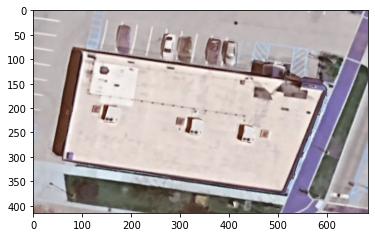

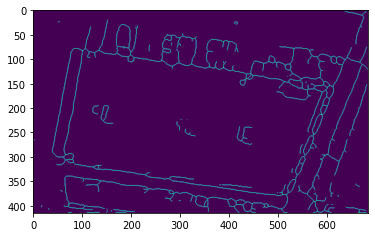

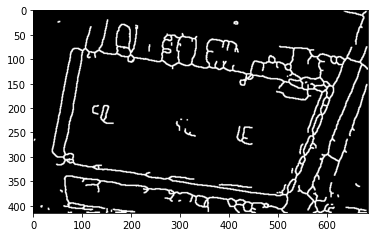

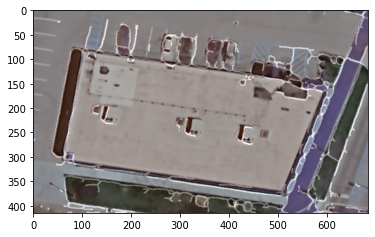

In [31]:
# Convert gradient magnitude image to 3 channels
fn = 'map1'
original = cv2.imread(f"{fn}.jpg", cv2.IMREAD_COLOR)
gradient_magnitude = cv2.imread(f"{fn}_edge.jpg", cv2.IMREAD_GRAYSCALE)
print(original.shape)
def enhance(orig, gm):
    # Convert gradient magnitude to a binary mask
    thresh = threshold_otsu(gm)
    binary = gm > thresh
    
    thinned = (bwmorph_thin(binary)* 255).astype(np.uint8)
    plt.imshow(thinned)
    plt.show()
    
    # Dilate the thinned mask a bit to make the edges wider
    kernel = np.ones((3,3),np.uint8)
    wider = cv2.dilate(thinned, kernel, iterations=1)
    
    plt.imshow(wider, cmap='gray')
    plt.show()
    
    # Convert eroded mask to 3 channels
    mask_colored = cv2.cvtColor(wider, cv2.COLOR_GRAY2BGR)
    plt.imshow(mask_colored)
    
    # Use the mask to blend between original and its edge-enhanced version
    alpha = 0.7  # blending factor. Adjust this value to your liking
    enhanced = cv2.addWeighted(orig, alpha, mask_colored, 1 - alpha, 0)

    plt.imshow(enhanced)
    plt.savefig(f"{fn}_enhanced_thin_white.png", bbox_inches='tight', pad_inches=0)
    
    plt.show()
plt.imshow(original)
plt.show()
enhance(original, gradient_magnitude)

(415, 685, 3)


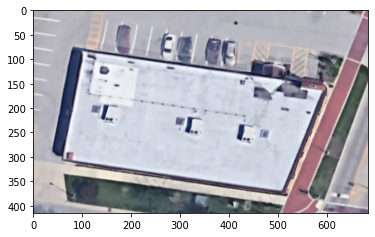

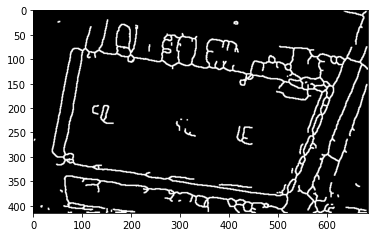

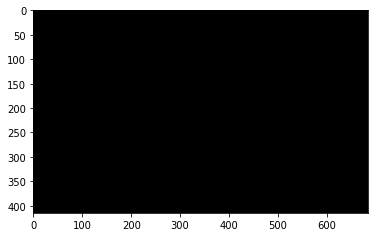

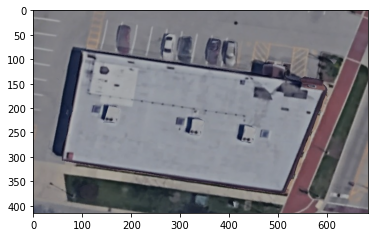

In [29]:
import cv2
import numpy as np
from skimage.filters import threshold_otsu
# from skimage.morphology import bwmorph_thin
import matplotlib.pyplot as plt

fn = 'map1'
original = cv2.imread(f"{fn}.jpg", cv2.IMREAD_COLOR)
gradient_magnitude = cv2.imread(f"{fn}_edge.jpg", cv2.IMREAD_GRAYSCALE)
print(original.shape)

def enhance(orig, gm):
    # Convert gradient magnitude to a binary mask
    thresh = threshold_otsu(gm)
    binary = gm > thresh
    
    thinned = (bwmorph_thin(binary) * 255).astype(np.uint8)
    
    # Dilate the thinned mask a bit to make the edges wider
    kernel = np.ones((3,3),np.uint8)
    wider = cv2.dilate(thinned, kernel, iterations=1)
    
    plt.imshow(wider, cmap='gray')
    plt.show()
    
    # Create a red mask from the dilated edges
    mask_colored = np.zeros((wider.shape[0], wider.shape[1], 3), dtype=np.uint8)
    # mask_colored[wider == 255] = [255, 0, 0]
    
    plt.imshow(mask_colored)
    plt.show()
    
    # Use the mask to blend between original and its edge-enhanced version
    alpha = 0.7  # blending factor. Adjust this value to your liking
    enhanced = cv2.addWeighted(orig, alpha, mask_colored, 1 - alpha, 0)

    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.savefig(f"{fn}_enhanced_thick_white.png", bbox_inches='tight', pad_inches=0)
    plt.show()

plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.show()
enhance(original, gradient_magnitude)


In [35]:
import cv2
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import os
from scipy import ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import threshold_otsu

def nabe(n):
    return np.array([n>>i&1 for i in range(0,9)]).astype(bool)

def hood(n):
    return np.take(nabe(n), np.array([[3, 2, 1],
                                      [4, 8, 0],
                                      [5, 6, 7]]))
def G1(n):
    s = 0
    bits = nabe(n)
    for i in (0,2,4,6):
        if not(bits[i]) and (bits[i+1] or bits[(i+2) % 8]):
            s += 1
    return s==1

g1_lut = np.array([G1(n) for n in range(256)])

def G2(n):
    n1, n2 = 0, 0
    bits = nabe(n)
    for k in (1,3,5,7):
        if bits[k] or bits[k-1]:
            n1 += 1
        if bits[k] or bits[(k+1) % 8]:
            n2 += 1
    return min(n1,n2) in [2,3]

g2_lut = np.array([G2(n) for n in range(256)])

g12_lut = g1_lut & g2_lut

def G3(n):
    bits = nabe(n)
    return not((bits[1] or bits[2] or not(bits[7])) and bits[0])

def G3p(n):
    bits = nabe(n)
    return not((bits[5] or bits[6] or not(bits[3])) and bits[4])

g3_lut = np.array([G3(n) for n in range(256)])
g3p_lut = np.array([G3p(n) for n in range(256)])

g123_lut  = g12_lut & g3_lut
g123p_lut = g12_lut & g3p_lut

def bwmorph_thin(image, n_iter=None):
    # check parameters
    if n_iter is None:
        n = -1
    elif n_iter <= 0:
        raise ValueError('n_iter must be > 0')
    else:
        n = n_iter

    # check that we have a 2d binary image, and convert it
    # to uint8
    skel = np.array(image).astype(np.uint8)

    if skel.ndim != 2:
        raise ValueError('2D array required')
    if not np.all(np.in1d(image.flat,(0,1))):
        raise ValueError('Image contains values other than 0 and 1')

    # neighborhood mask
    mask = np.array([[ 8,  4,  2],
                     [16,  0,  1],
                     [32, 64,128]],dtype=np.uint8)

    # iterate either 1) indefinitely or 2) up to iteration limit
    while n != 0:
        before = np.sum(skel) # count points before thinning

        # for each subiteration
        for lut in [g123_lut, g123p_lut]:
            # correlate image with neighborhood mask
            N = ndi.correlate(skel, mask, mode='constant')
            # take deletion decision from this subiteration's LUT
            D = np.take(lut, N)
            # perform deletion
            skel[D] = 0

        after = np.sum(skel) # coint points after thinning

        if before == after:
            # iteration had no effect: finish
            break

        # count down to iteration limit (or endlessly negative)
        n -= 1

    return skel.astype(bool)

def enhance(orig, gm):
    # Convert gradient magnitude to a binary mask
    thresh = threshold_otsu(gm)
    binary = gm > thresh
    
    thinned = (bwmorph_thin(binary) * 255).astype(np.uint8)
    
    # Dilate the thinned mask a bit to make the edges wider
    kernel = np.ones((3,3),np.uint8)
    wider = cv2.dilate(thinned, kernel, iterations=1)
    
    # Convert dilated mask to 3 channels
    mask_colored = cv2.cvtColor(wider, cv2.COLOR_GRAY2BGR)
    
    # Use the mask to blend between original and its edge-enhanced version
    alpha = 0.7  # blending factor
    enhanced = cv2.addWeighted(orig, alpha, mask_colored, 1 - alpha, 0)
    return enhanced

base_path = "../"
edge_dir = os.path.join(base_path, "train_thick_edge/")
original_dir = os.path.join(base_path, "train_original/")
output_dir = os.path.join(base_path, "train/")

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get list of png files in the edge directory
file_list = [f for f in os.listdir(edge_dir) if f.endswith('.jpg')]
print(len(file_list))
for file_name in file_list:
    edge_img_path = os.path.join(edge_dir, file_name)
    original_img_path = os.path.join(original_dir, file_name)
    
    # Ensure both the edge and original image exists
    if os.path.exists(edge_img_path) and os.path.exists(original_img_path):
        original = cv2.imread(original_img_path, cv2.IMREAD_COLOR)
        gradient_magnitude = cv2.imread(edge_img_path, cv2.IMREAD_GRAYSCALE)
        
        enhanced_img = enhance(original, gradient_magnitude)
        output_path = os.path.join(output_dir, file_name)
        
        cv2.imwrite(output_path, enhanced_img)


7501
